In [3]:
import numpy as np
import boto3
import awswrangler as wr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from src.utils import read_configuration
# config
global_config = read_configuration()

In [6]:
session = boto3.Session(profile_name=global_config['main']['aws_profile'])

In [7]:
query = '''select
    in_.fecha,
    in_.dato as inflacion,
    ti.dato as tasa_de_interes,
    tc.dato as tipo_de_cambio
from
    econ.inflacion as in_
    join econ.tiie as ti
        on ti.fecha = in_.fecha
    join econ.tipo_de_cambio as tc
        on tc.fecha = in_.fecha'''
df = wr.athena.read_sql_query(
    query, 
    database="econ", 
    ctas_approach=False,
    boto3_session=session
)

In [9]:
def entrenar_modelo_regresion_lineal(X, Y):
    # Verificar que X e Y tienen el mismo tamaño
    if len(X) != len(Y):
        raise ValueError("X e Y deben tener el mismo tamaño.")
    # Reshape de X para asegurar la forma correcta
    X_reshaped = X.values.reshape(-1, 1)
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y, test_size=0.2, random_state=42)
    # Crear el modelo de regresión lineal
    modelo = LinearRegression()
    # Entrenar el modelo
    modelo.fit(X_train, Y_train)
    # Predecir utilizando el conjunto de prueba
    Y_pred = modelo.predict(X_test)
    # Calcular el error cuadrático medio para evaluar el modelo
    mse = mean_squared_error(Y_test, Y_pred)
    print("Modelo entrenado. Error Cuadrático Medio (MSE):", mse)
    return modelo

In [16]:
# tipo_de_cambio ~ tasa_de_interes
model_1 = entrenar_modelo_regresion_lineal(df['tasa_de_interes'],df['tipo_de_cambio'])
model_2 = entrenar_modelo_regresion_lineal(df['tasa_de_interes'],df['inflacion'])
model_3 = entrenar_modelo_regresion_lineal(df['tipo_de_cambio'],df['inflacion'])

Modelo entrenado. Error Cuadrático Medio (MSE): 14.860741492308328
Modelo entrenado. Error Cuadrático Medio (MSE): 0.00015464399325420758
Modelo entrenado. Error Cuadrático Medio (MSE): 0.0002873072644878739


In [17]:
def graficar_modelo_y_datos(X, Y, model):
    # Convertir X a numpy array si aún no lo es
    X_array = X.values.reshape(-1, 1) if hasattr(X, "values") else X
    # Generar valores X para la línea de regresión
    X_linea = np.linspace(X_array.min(), X_array.max(), 100).reshape(-1, 1)
    # Calcular valores Y para la línea de regresión
    Y_linea = model.predict(X_linea)
    # Graficar los datos originales
    plt.scatter(X, Y, color='blue', label='Datos originales')
    # Graficar la línea de regresión
    plt.plot(X_linea, Y_linea, color='red', label='Línea de regresión')
    # Agregar título y leyenda
    plt.title('Scatter Plot de los Datos y Línea de Regresión')
    plt.xlabel('X')
    plt.ylabel('Y')
    # Mostrar el gráfico
    plt.show()

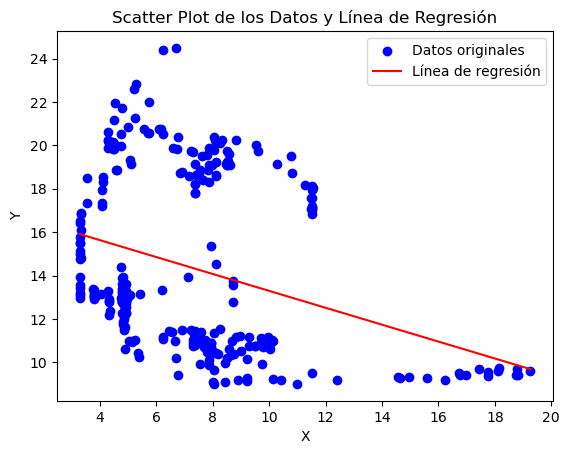

In [18]:
graficar_modelo_y_datos(df['tasa_de_interes'],df['tipo_de_cambio'],model_1)

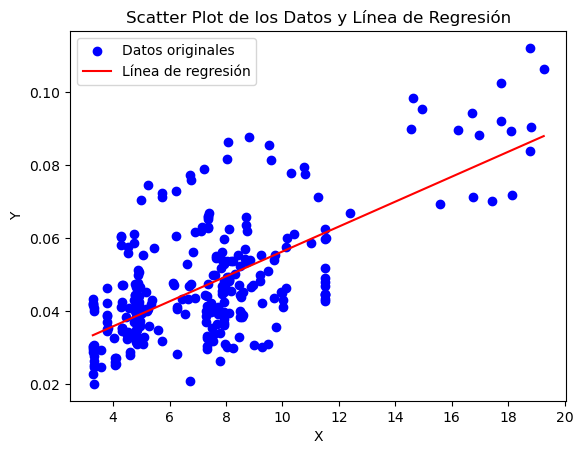

In [19]:
graficar_modelo_y_datos(df['tasa_de_interes'],df['inflacion'],model_2)

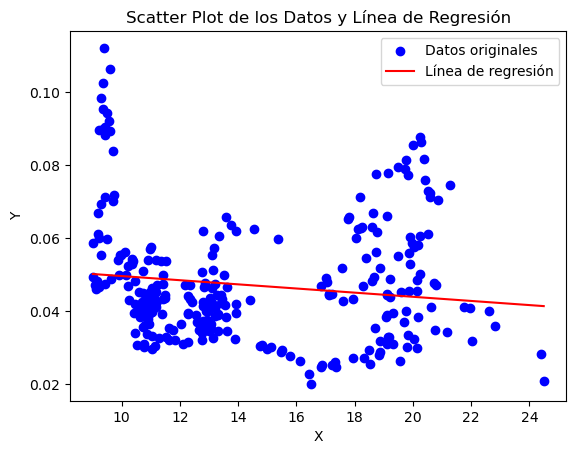

In [20]:
graficar_modelo_y_datos(df['tipo_de_cambio'],df['inflacion'],model_3)